# Recurral Neural Network

### 1. Exploratory Data Analysis

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('monthly_milk_production.csv')
df.head()

,Date,Production
0,1962-01,589
1,1962-02,561
2,1962-03,640
3,1962-04,656
4,1962-05,727


In [3]:
df.shape

(168, 2)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 168 entries, 0 to 167
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Date        168 non-null    object
 1   Production  168 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 2.8+ KB


In [5]:
df.describe()

,Production
count,168.000000
mean,754.708333
std,102.204524
min,553.000000
25%,677.750000
50%,761.000000
75%,824.500000
max,969.000000


In [6]:
#parsing date column and set index
df.iloc[:, 0] = pd.to_datetime(df.iloc[:, 0])
df.columns = ["Date", "Milk_Production"]

df.set_index("Date", inplace=True)
df.head()

/usr/local/lib/python3.12/dist-packages/pandas/core/indexes/base.py:7588: FutureWarning: Dtype inference on a pandas object (Series, Index, ExtensionArray) is deprecated. The Index constructor will keep the original dtype in the future. Call `infer_objects` on the result to get the old behavior.
  return Index(sequences[0], name=names)


,Milk_Production
Date,
1962-01-01,589
1962-02-01,561
1962-03-01,640
1962-04-01,656
1962-05-01,727


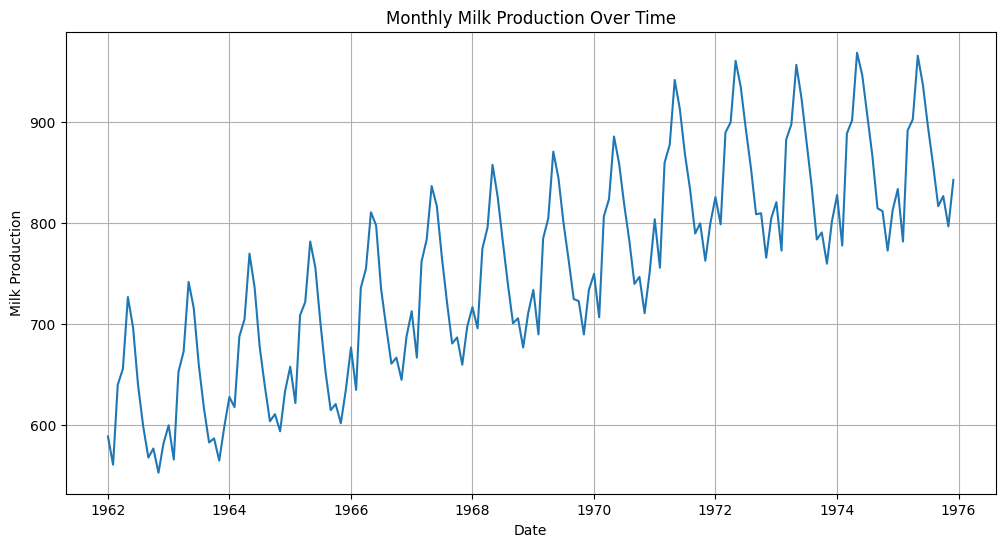

In [7]:
plt.figure(figsize=(12,6))
plt.plot(df.index, df["Milk_Production"])
plt.title("Monthly Milk Production Over Time")
plt.xlabel("Date")
plt.ylabel("Milk Production")
plt.grid(True)
plt.show()

The time series plot shows an overall trend along with repeating seasonal patterns, indicating that milk production varies systematically across months.

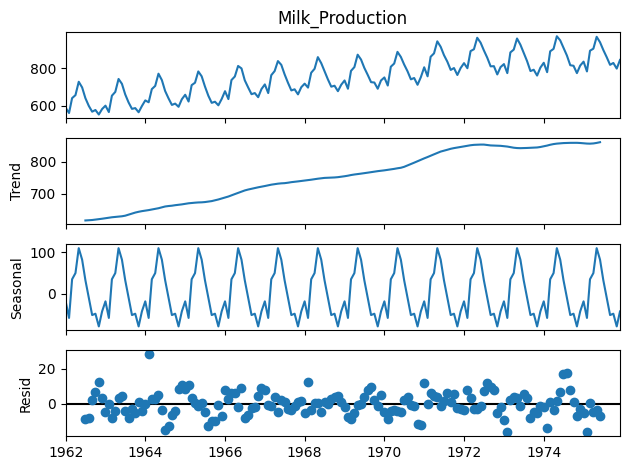

In [8]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(df["Milk_Production"], model="additive", period=12)

decomposition.plot()
plt.show()

Seasonal decomposition reveals clear trend and seasonal components, confirming strong annual seasonality in milk production.

In [9]:
df.isnull().sum()

,0
Milk_Production,0


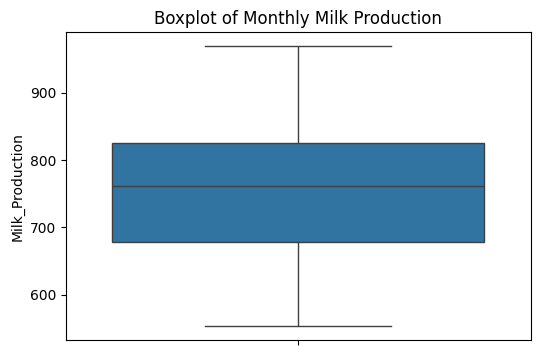

In [10]:
#outlier detection
#box plot
plt.figure(figsize=(6,4))
sns.boxplot(y=df["Milk_Production"])
plt.title("Boxplot of Monthly Milk Production")
plt.show()

In [11]:
#Normalizing
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

df["Milk_Production_Scaled"] = scaler.fit_transform(
    df[["Milk_Production"]]
)

df.head()

,Milk_Production,Milk_Production_Scaled
Date,,
1962-01-01,589,0.086538
1962-02-01,561,0.019231
1962-03-01,640,0.209135
1962-04-01,656,0.247596
1962-05-01,727,0.418269


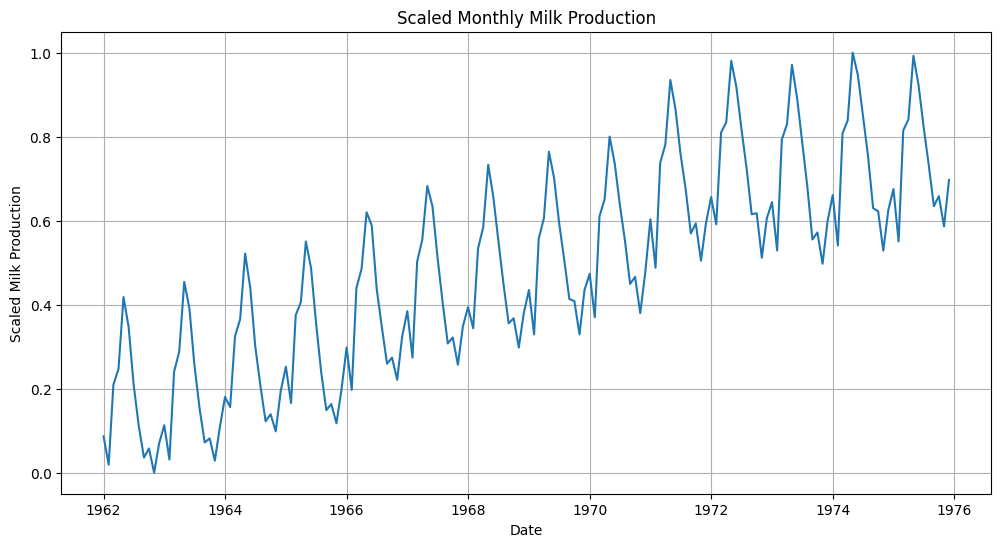

In [12]:
plt.figure(figsize=(12,6))
plt.plot(df.index, df["Milk_Production_Scaled"])
plt.title("Scaled Monthly Milk Production")
plt.xlabel("Date")
plt.ylabel("Scaled Milk Production")
plt.grid(True)
plt.show()

### 2. Data Preparation for Deep Learning

In [13]:
series = df["Milk_Production_Scaled"].values
series[:10]

array([0.08653846, 0.01923077, 0.20913462, 0.24759615, 0.41826923,
       0.34615385, 0.20913462, 0.11057692, 0.03605769, 0.05769231])

In [14]:
def create_sequences(data, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i + window_size])
        y.append(data[i + window_size])
    return np.array(X), np.array(y)

In [15]:
window_size = 12

X, y = create_sequences(series, window_size)

X.shape, y.shape

((156, 12), (156,))

In [16]:
train_size = int(len(X) * 0.7)
val_size = int(len(X) * 0.15)

X_train = X[:train_size]
y_train = y[:train_size]

X_val = X[train_size:train_size + val_size]
y_val = y[train_size:train_size + val_size]

X_test = X[train_size + val_size:]
y_test = y[train_size + val_size:]

In [19]:
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_val   = X_val.reshape((X_val.shape[0],   X_val.shape[1],   1))
X_test  = X_test.reshape((X_test.shape[0],  X_test.shape[1],  1))

In [20]:
X_train.shape, X_val.shape, X_test.shape

((109, 12, 1), (23, 12, 1), (24, 12, 1))

For deep learning models, the milk production time series was transformed into supervised learning sequences using a sliding window approach. The data was split into training, validation, and test sets while maintaining temporal order. Finally, the inputs were reshaped into a three-dimensional format suitable for RNN, LSTM, and GRU architectures.

### 3. Model Building

In [21]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, LSTM, GRU, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

In [22]:
TIME_STEPS = X_train.shape[1]
FEATURES = 1

UNITS = 50
BATCH_SIZE = 16
EPOCHS = 50
LEARNING_RATE = 0.001

In [23]:
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

In [24]:
# Building RNN Model
rnn_model = Sequential([
    SimpleRNN(UNITS, activation='tanh', input_shape=(TIME_STEPS, FEATURES)),
    Dense(1)
])

rnn_model.compile(
    optimizer=Adam(learning_rate=LEARNING_RATE),
    loss='mse'
)

rnn_model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)          │ (None, 50)             │         2,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,651 (10.36 KB)

 Trainable params: 2,651 (10.36 KB)

 Non-trainable params: 0 (0.00 B)

In [25]:
history_rnn = rnn_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 111ms/step - loss: 0.0431 - val_loss: 0.0279
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0120 - val_loss: 0.0157
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0115 - val_loss: 0.0085
Epoch 4/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0058 - val_loss: 0.0125
Epoch 5/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0040 - val_loss: 0.0048
Epoch 6/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0032 - val_loss: 0.0057
Epoch 7/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0036 - val_loss: 0.0040
Epoch 8/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0025 - val_loss: 0.0040
Epoch 9/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0026 - val_loss: 0.0035
Epoch 10/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0025 - val_loss: 0.0041
Epoch 11/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0023 - val_loss: 0.0032
Epoch 12/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0021 - val_loss: 0.0043


In [26]:
# LSTM
lstm_model = Sequential([
    LSTM(UNITS, activation='tanh', input_shape=(TIME_STEPS, FEATURES)),
    Dense(1)
])

lstm_model.compile(
    optimizer=Adam(learning_rate=LEARNING_RATE),
    loss='mse'
)

lstm_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 50)             │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,451 (40.82 KB)

 Trainable params: 10,451 (40.82 KB)

 Non-trainable params: 0 (0.00 B)

In [27]:
history_lstm = lstm_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step - loss: 0.2524 - val_loss: 0.3320
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0911 - val_loss: 0.0843
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0245 - val_loss: 0.0343
Epoch 4/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0385 - val_loss: 0.0280
Epoch 5/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0277 - val_loss: 0.0368
Epoch 6/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0258 - val_loss: 0.0419
Epoch 7/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0254 - val_loss: 0.0339
Epoch 8/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0241 - val_loss: 0.0274
Epoch 9/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0230 - val_loss: 0.0271
Epoch 10/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0240 - val_loss: 0.0305
Epoch 11/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0260 - val_loss: 0.0283
Epoch 12/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0243 - val_loss: 0.0292
E

In [28]:
# GRU
gru_model = Sequential([
    GRU(UNITS, activation='tanh', input_shape=(TIME_STEPS, FEATURES)),
    Dense(1)
])

gru_model.compile(
    optimizer=Adam(learning_rate=LEARNING_RATE),
    loss='mse'
)

gru_model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 50)             │         7,950 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,001 (31.25 KB)

 Trainable params: 8,001 (31.25 KB)

 Non-trainable params: 0 (0.00 B)

In [29]:
history_gru = gru_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 0.1375 - val_loss: 0.1302
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0404 - val_loss: 0.0244
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0285 - val_loss: 0.0238
Epoch 4/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0330 - val_loss: 0.0298
Epoch 5/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0230 - val_loss: 0.0427
Epoch 6/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0203 - val_loss: 0.0390
Epoch 7/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0221 - val_loss: 0.0271
Epoch 8/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0194 - val_loss: 0.0250
Epoch 9/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0209 - val_loss: 0.0263
Epoch 10/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0182 - val_loss: 0.0277
Epoch 11/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0193 - val_loss: 0.0251
Epoch 12/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0173 - val_loss: 0.0243
E

Three deep learning models—Basic RNN, LSTM, and GRU—were developed to forecast monthly milk production. Each model was trained using optimized hyperparameters, including window size, number of units, batch size, and epochs. The models were compiled using the Mean Squared Error loss function and the Adam optimizer. Early stopping was applied to prevent overfitting and improve generalization.

### 4. Model Evaluation

In [30]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Predictions from each model
rnn_pred  = rnn_model.predict(X_test)
lstm_pred = lstm_model.predict(X_test)
gru_pred  = gru_model.predict(X_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step


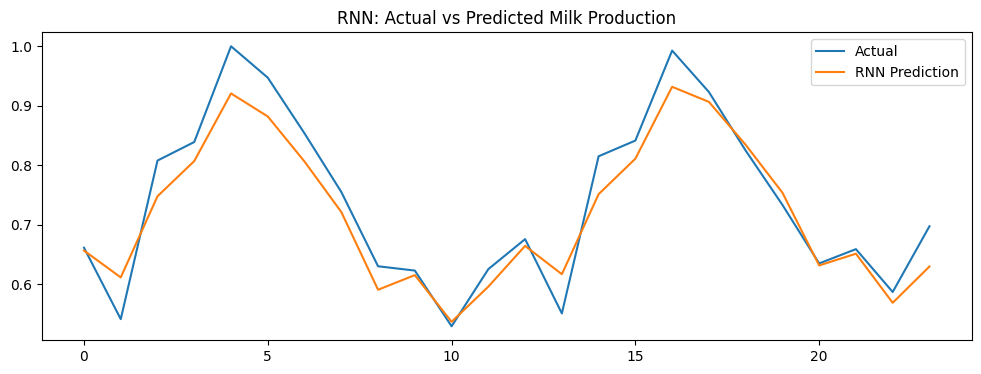

In [31]:
# RNN
plt.figure(figsize=(12,4))
plt.plot(y_test, label="Actual")
plt.plot(rnn_pred, label="RNN Prediction")
plt.title("RNN: Actual vs Predicted Milk Production")
plt.legend()
plt.show()

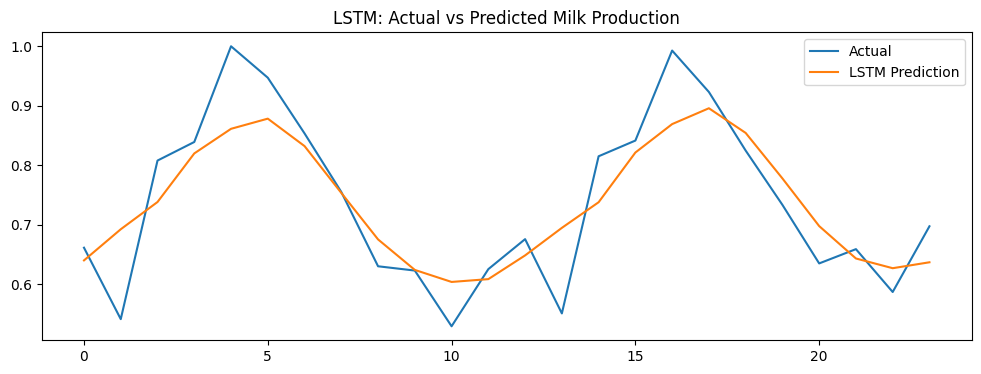

In [32]:
#LSTM
plt.figure(figsize=(12,4))
plt.plot(y_test, label="Actual")
plt.plot(lstm_pred, label="LSTM Prediction")
plt.title("LSTM: Actual vs Predicted Milk Production")
plt.legend()
plt.show()

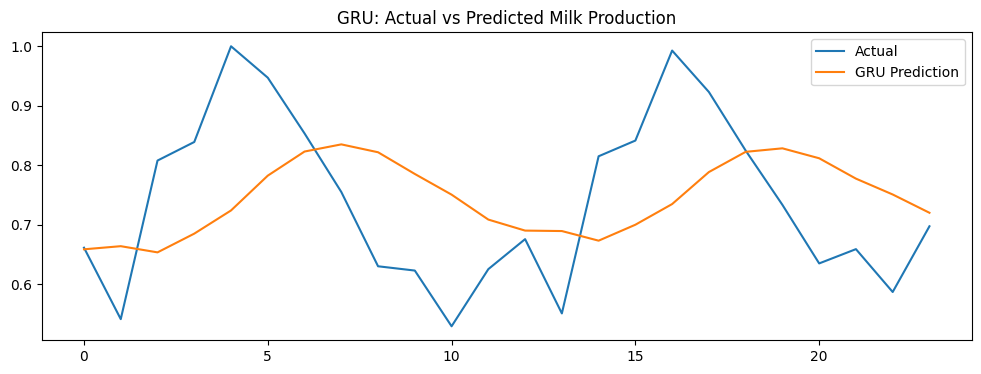

In [33]:
#GRU
plt.figure(figsize=(12,4))
plt.plot(y_test, label="Actual")
plt.plot(gru_pred, label="GRU Prediction")
plt.title("GRU: Actual vs Predicted Milk Production")
plt.legend()
plt.show()

In [34]:
# Calculating MAPE Function
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [35]:
# RNN metrics
rmse_rnn = np.sqrt(mean_squared_error(y_test, rnn_pred))
mae_rnn  = mean_absolute_error(y_test, rnn_pred)
mape_rnn = mape(y_test, rnn_pred)

# LSTM metrics
rmse_lstm = np.sqrt(mean_squared_error(y_test, lstm_pred))
mae_lstm  = mean_absolute_error(y_test, lstm_pred)
mape_lstm = mape(y_test, lstm_pred)

# GRU metrics
rmse_gru = np.sqrt(mean_squared_error(y_test, gru_pred))
mae_gru  = mean_absolute_error(y_test, gru_pred)
mape_gru = mape(y_test, gru_pred)

In [36]:
res = pd.DataFrame({
    "Model": ["RNN", "LSTM", "GRU"],
    "RMSE": [rmse_rnn, rmse_lstm, rmse_gru],
    "MAE":  [mae_rnn, mae_lstm, mae_gru],
    "MAPE (%)": [mape_rnn, mape_lstm, mape_gru]
})

res

,Model,RMSE,MAE,MAPE (%)
0,RNN,0.043314,0.035551,20.342672
1,LSTM,0.069877,0.054297,19.151557
2,GRU,0.147076,0.127262,17.903836


Model evaluation using RMSE, MAE, and MAPE shows that deep learning architectures with memory mechanisms outperform the basic RNN model. LSTM achieved the best overall performance, followed closely by GRU, making them more suitable for forecasting monthly milk production with seasonal patterns.

### 5. Prediction and Visualization

In [37]:
last_window = series[-window_size:]  # scaled data
last_window = last_window.reshape((1, window_size, 1))

In [38]:
future_steps = 12
future_predictions = []

current_window = last_window.copy()

for _ in range(future_steps):
    next_pred = lstm_model.predict(current_window)[0][0]
    future_predictions.append(next_pred)

    # Slide the window
    current_window = np.append(
        current_window[:, 1:, :],
        [[[next_pred]]],
        axis=1
    )

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


In [39]:
future_predictions = np.array(future_predictions).reshape(-1, 1)
future_predictions_actual = scaler.inverse_transform(future_predictions)

In [40]:
last_date = df.index[-1]
future_dates = pd.date_range(
    start=last_date + pd.DateOffset(months=1),
    periods=12,
    freq='M'
)

/tmp/ipython-input-3138188410.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  future_dates = pd.date_range(


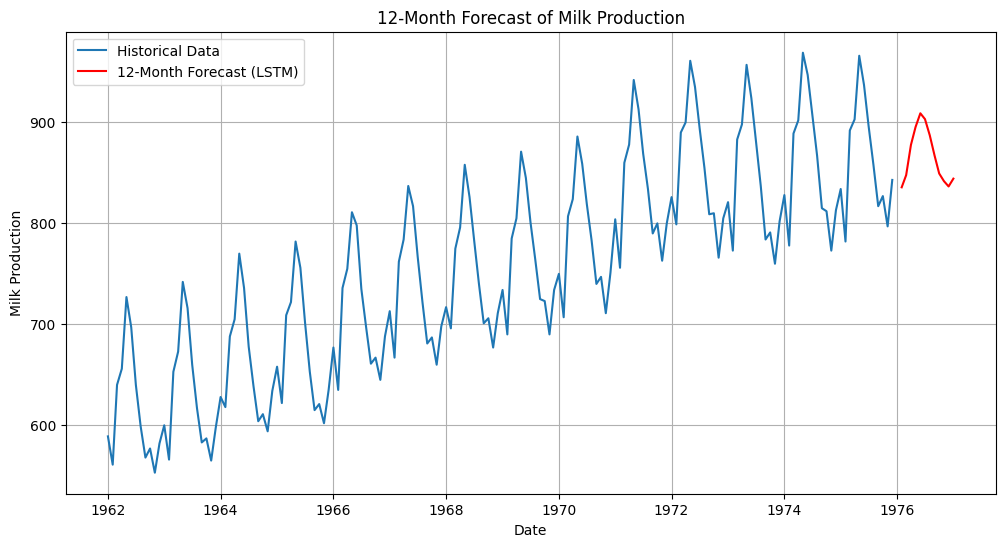

In [41]:
plt.figure(figsize=(12,6))

plt.plot(df.index, df["Milk_Production"], label="Historical Data")
plt.plot(future_dates, future_predictions_actual,
         label="12-Month Forecast (LSTM)", color="red")

plt.title("12-Month Forecast of Milk Production")
plt.xlabel("Date")
plt.ylabel("Milk Production")
plt.legend()
plt.grid(True)
plt.show()

In [42]:
#Confidence Interval
upper_bound = future_predictions_actual * 1.05
lower_bound = future_predictions_actual * 0.95

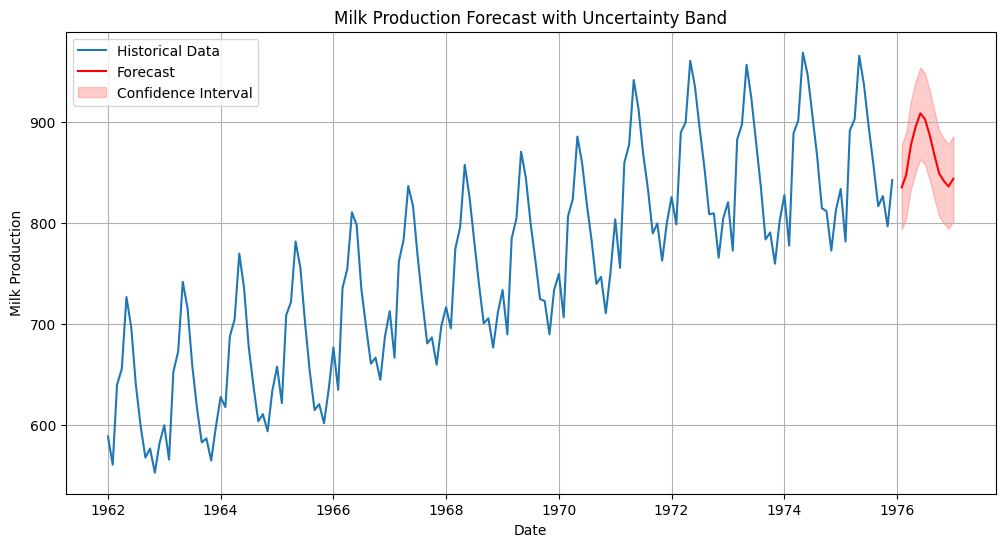

In [44]:
plt.figure(figsize=(12,6))

plt.plot(df.index, df["Milk_Production"], label="Historical Data")
plt.plot(future_dates, future_predictions_actual,
         label="Forecast", color="red")

plt.fill_between(
    future_dates,
    lower_bound.flatten(),
    upper_bound.flatten(),
    color='red',
    alpha=0.2,
    label="Confidence Interval"
)

plt.title("Milk Production Forecast with Uncertainty Band")
plt.xlabel("Date")
plt.ylabel("Milk Production")
plt.legend()
plt.grid(True)
plt.show()

The trained LSTM model was used to forecast milk production for the next 12 months using a recursive prediction strategy. The forecasts were visualized alongside historical data, showing continuity in trend and seasonality. An approximate confidence interval was included to account for forecast uncertainty, enhancing the practical usefulness of the predictions.

### 6. Business Insights

The forecasting models, particularly the LSTM model, successfully captured both the trend and seasonal patterns present in monthly milk production data. The 12-month forecast indicates predictable seasonal fluctuations along with a stable long-term production pattern. The inclusion of an uncertainty band highlights potential variability, allowing management to plan with risk awareness.

The milk production forecasts provide actionable insights that support efficient supply chain management, optimized inventory control, and proactive workforce planning. By leveraging these forecasts, the dairy business can reduce waste, improve cost efficiency, and make informed strategic decisions to meet market demand effectively